In [117]:
import pysam # count variant alleles from BAM
import pandas as pd # data frames
import numpy as np # arrays
import os # interacting with files
from Bio import SeqIO # reading fasta format
import re # regular expressions
import seaborn as sns
from skbio.stats.distance import DissimilarityMatrix # plot the cluster heatmap
from collections import Counter

In [111]:
def get_bam_paths(dirpath, pattern = ".sorted.marked.merged.bam"):
    """
    Function to get the BAM paths in a list.
    """
    return [os.path.join(root,file) for root, dirs, files in os.walk(dirpath) for file in files if file.endswith(pattern)]


def get_ref_sequence(refpath):
    """
    Function to read in the reference sequence as a list.
    """
    return [base.upper() for base in list(SeqIO.parse(refpath, "fasta"))[0].seq]


def get_sample_info(filepath):
    """
    Get the sample and the replicate from the path.
    """
    metadata = re.split("\\.|_", os.path.basename(filepath))
    return (metadata[0], metadata[1])


def check_read(read):
    """
    Helper function to decide what reads should
    be keep when parsing alignment file with `pysam`. 
    """
    # Exclude Quality Failures
    if read.is_qcfail:
        return False
    # Exclude Secondary Mappings
    if read.is_secondary:
        return False
    # Exclude Unmapped Reads
    if read.is_unmapped:
        return False
    else:
        return True

    
def build_consensus_seq(
                bampath, 
                callback_function = check_read, 
                contig = "NC_045512.2", 
                refpath = "../../config/ref/SARS2.fa", 
                minimum_QUAL = 25, 
                minimum_COV = 100):
    """
    Read in BAM file and convert to a consensus fasta the length of the
    reference genome using the `pysam` command `count_coverage`. 
    """
     # String to hold the final consensus seq
    consensus = ""
    # Open alignment with pysam
    with pysam.AlignmentFile(bampath, "rb") as bamfile:
        # Get a dataframe of the counts
        count_df = pd.DataFrame.from_dict({base:counts for base, counts in zip("ACGT", bamfile.count_coverage(contig = contig, read_callback=callback_function, quality_threshold=minimum_QUAL))})
        # Add the depth at each position
        count_df['DP'] = count_df.sum(axis = 1)
        # Add the position 
        count_df['POS'] = count_df.index + 1
        # Add the reference allele
        count_df['REF'] = get_ref_sequence(refpath)
        # Convert counts to frequency 
        count_df.iloc[:,0:4] = count_df.iloc[:,0:4].div(count_df.DP, axis = 0)
        # Handle any NaNs created by dividing by 0 coverage
        count_df = count_df.fillna(0)
        # Iterate over each row and determine the conesnus sequence and build consensus string
        for index, row in count_df.iterrows(): 
            if row.DP < minimum_COV:
                consensus += "N"
            else: 
                consensus += max([(row["A"], "A"), (row["C"], "C"), (row["G"], "G"), (row["T"], "T")],key=lambda x:x[0])[1]
            
        return consensus
    

def merge_consensus_seq(consensus_1, consensus_2, sample):
    """
    Combine the consensus sequences between the two replicates using higher coverage
    reigons of each replicate to fill in gaps. 
    """
    collated_consensus = ""
    discrepencies = []
    for pos, bases in enumerate(zip(consensus_1, consensus_2)): 
        # Mask the last 40 bases or so of the genome (repetative poly-A track)
        if pos+1 >= 29860:
            collated_consensus += 'N'
            continue
        if bases[0] == bases[1]:
            collated_consensus += bases[0]
        else: 
            if 'N' in bases: 
                if set(bases) == {'N'}:
                    collated_consensus += 'N'
                else: 
                    if bases[0] == 'N':
                        collated_consensus += bases[1]
                    else: 
                        collated_consensus += bases[0]
            else:
                print(f"Warning! There is a discrepency in highly covered bases at position {pos+1} for sample {sample}: {bases}")
                collated_consensus += 'N'
    return collated_consensus
    
    
def normalize_Ns(consensus_dict):
    """
    Normalize the masked regions of the genome by identfying 
    where coverage was too low in all samples. Normalizing which 
    regions should be considered Ns.
    """
    mask = set()
    for consensus in consensus_dict.values():
        for pos,base in enumerate(consensus):
            if base == "N":
                mask.add(pos)
    print(f"There are {len(mask)} bases being masked by N's because of low coverage.")
    return {sample:"".join('N' if pos in mask else base for pos, base in enumerate(consensus)) for sample, consensus in consensus_dict.items()}
        

def hamming_distance(chaine1, chaine2):
    """
    Calculate the edit distance between masked consensus genomes.
    """
    return sum(c1 != c2 for c1, c2 in zip(chaine1, chaine2))
    

In [91]:
# Iterate over the samples and make a rough consensus sequence. 
consensus_dict = {get_sample_info(bampath):build_consensus_seq(bampath) for bampath in get_bam_paths("../../results/aligned/BWA/")}


In [105]:
kgtc
        

There are 204 bases being masked by N's because of low coverage.


In [115]:
distances = list()
for m, i in normalized_consensus_dict.items():
    for n, j in normalized_consensus_dict.items():
        distances.append((f"{m}", f"{n}",hamming_distance(i,j)))      

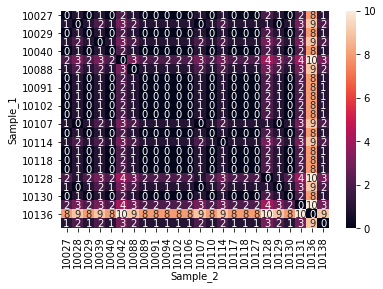

In [118]:
edit_distance_df = pd.DataFrame(distances, columns = ["Sample_1", "Sample_2", "Edit_Distance"]).pivot("Sample_1", "Sample_2", "Edit_Distance")

ax = sns.heatmap(edit_distance_df, annot=True, fmt="d")

In [126]:
ref = get_ref_sequence("../../config/ref/SARS2.fa")

for pos, base in enumerate(normalized_consensus_dict['10131']):
    if base == 'N': 
        ref[pos] = 'N'

hamming_distance(normalized_consensus_dict['10131'],''.join(ref))

11